In [10]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('Tot_dep_2017_Aug_mult.csv', usecols=[1,2,3,4,5,6], engine='python')
# manually specify column names
dataset.columns = ['DDA','TOT','MMDA','SAV','IRA','CD']
#dataset.index.name = 'date'
# mark all NA values with 0
#dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
#dataset = dataset[1:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('Tot_dep_2017_Aug_multV2.csv')

      DDA      TOT    MMDA     SAV    IRA      CD
0  621848  2047542  849766  153982  85277  336670
1  629182  2064871  859274  158249  84967  333199
2  654617  2105241  872873  165765  84300  327686
3  666697  2113492  874853  168101  84130  319710
4  644868  2088118  875964  168762  83786  314738


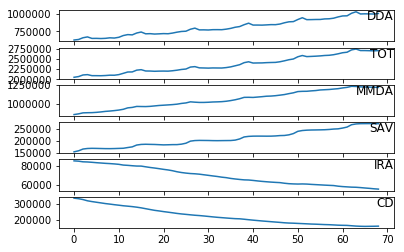

In [11]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('Tot_dep_2017_Aug_multV2.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0,1,2,3,4,5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [12]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('Tot_dep_2017_Aug_multV2.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.000000   0.000000   0.000000   0.000000   1.000000   1.000000  0.017934
2   0.017934   0.024675   0.024764   0.035827   0.989475   0.980779  0.080133
3   0.080133   0.082158   0.060184   0.098934   0.966828   0.950251  0.109673
4   0.109673   0.093907   0.065341   0.118547   0.961057   0.906083  0.056293
5   0.056293   0.057777   0.068234   0.124097   0.949377   0.878550  0.058149


In [13]:
# split into train and test sets
values = reframed.values
n_train_hours = 48
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(48, 1, 6) (48,) (20, 1, 6) (20,)


Train on 48 samples, validate on 20 samples
Epoch 1/2000
2s - loss: 0.1728 - val_loss: 0.5278
Epoch 2/2000
0s - loss: 0.1671 - val_loss: 0.5231
Epoch 3/2000
0s - loss: 0.1596 - val_loss: 0.5183
Epoch 4/2000
0s - loss: 0.1583 - val_loss: 0.5134
Epoch 5/2000
0s - loss: 0.1574 - val_loss: 0.5086
Epoch 6/2000
0s - loss: 0.1535 - val_loss: 0.5037
Epoch 7/2000
0s - loss: 0.1522 - val_loss: 0.4989
Epoch 8/2000
0s - loss: 0.1476 - val_loss: 0.4941
Epoch 9/2000
0s - loss: 0.1456 - val_loss: 0.4894
Epoch 10/2000
0s - loss: 0.1456 - val_loss: 0.4847
Epoch 11/2000
0s - loss: 0.1371 - val_loss: 0.4800
Epoch 12/2000
0s - loss: 0.1360 - val_loss: 0.4753
Epoch 13/2000
0s - loss: 0.1361 - val_loss: 0.4707
Epoch 14/2000
0s - loss: 0.1353 - val_loss: 0.4662
Epoch 15/2000
0s - loss: 0.1404 - val_loss: 0.4617
Epoch 16/2000
0s - loss: 0.1273 - val_loss: 0.4573
Epoch 17/2000
0s - loss: 0.1315 - val_loss: 0.4530
Epoch 18/2000
0s - loss: 0.1302 - val_loss: 0.4486
Epoch 19/2000
0s - loss: 0.1241 - val_loss: 0.4

Epoch 188/2000
0s - loss: 0.0060 - val_loss: 0.0464
Epoch 189/2000
0s - loss: 0.0102 - val_loss: 0.0460
Epoch 190/2000
0s - loss: 0.0090 - val_loss: 0.0457
Epoch 191/2000
0s - loss: 0.0058 - val_loss: 0.0453
Epoch 192/2000
0s - loss: 0.0102 - val_loss: 0.0450
Epoch 193/2000
0s - loss: 0.0062 - val_loss: 0.0446
Epoch 194/2000
0s - loss: 0.0061 - val_loss: 0.0443
Epoch 195/2000
0s - loss: 0.0067 - val_loss: 0.0440
Epoch 196/2000
0s - loss: 0.0101 - val_loss: 0.0437
Epoch 197/2000
0s - loss: 0.0026 - val_loss: 0.0434
Epoch 198/2000
0s - loss: 0.0045 - val_loss: 0.0432
Epoch 199/2000
0s - loss: 0.0068 - val_loss: 0.0429
Epoch 200/2000
0s - loss: 0.0084 - val_loss: 0.0427
Epoch 201/2000
0s - loss: 0.0039 - val_loss: 0.0425
Epoch 202/2000
0s - loss: 0.0050 - val_loss: 0.0423
Epoch 203/2000
0s - loss: 0.0049 - val_loss: 0.0421
Epoch 204/2000
0s - loss: 0.0052 - val_loss: 0.0419
Epoch 205/2000
0s - loss: 0.0114 - val_loss: 0.0417
Epoch 206/2000
0s - loss: 0.0067 - val_loss: 0.0415
Epoch 207/20

Epoch 381/2000
0s - loss: 0.0031 - val_loss: 0.0287
Epoch 382/2000
0s - loss: 0.0079 - val_loss: 0.0285
Epoch 383/2000
0s - loss: 0.0070 - val_loss: 0.0284
Epoch 384/2000
0s - loss: 0.0061 - val_loss: 0.0283
Epoch 385/2000
0s - loss: 0.0095 - val_loss: 0.0281
Epoch 386/2000
0s - loss: 0.0036 - val_loss: 0.0280
Epoch 387/2000
0s - loss: 0.0078 - val_loss: 0.0279
Epoch 388/2000
0s - loss: 0.0114 - val_loss: 0.0277
Epoch 389/2000
0s - loss: 0.0081 - val_loss: 0.0276
Epoch 390/2000
0s - loss: 0.0036 - val_loss: 0.0275
Epoch 391/2000
0s - loss: 0.0071 - val_loss: 0.0274
Epoch 392/2000
0s - loss: 0.0046 - val_loss: 0.0273
Epoch 393/2000
0s - loss: 0.0064 - val_loss: 0.0272
Epoch 394/2000
0s - loss: 0.0055 - val_loss: 0.0272
Epoch 395/2000
0s - loss: 0.0082 - val_loss: 0.0271
Epoch 396/2000
0s - loss: 0.0094 - val_loss: 0.0270
Epoch 397/2000
0s - loss: 0.0049 - val_loss: 0.0270
Epoch 398/2000
0s - loss: 0.0067 - val_loss: 0.0269
Epoch 399/2000
0s - loss: 0.0093 - val_loss: 0.0269
Epoch 400/20

Epoch 575/2000
0s - loss: 0.0087 - val_loss: 0.0221
Epoch 576/2000
0s - loss: 0.0050 - val_loss: 0.0220
Epoch 577/2000
0s - loss: 0.0065 - val_loss: 0.0219
Epoch 578/2000
0s - loss: 0.0047 - val_loss: 0.0218
Epoch 579/2000
0s - loss: 0.0054 - val_loss: 0.0217
Epoch 580/2000
0s - loss: 0.0043 - val_loss: 0.0216
Epoch 581/2000
0s - loss: 0.0082 - val_loss: 0.0215
Epoch 582/2000
0s - loss: 0.0036 - val_loss: 0.0215
Epoch 583/2000
0s - loss: 0.0046 - val_loss: 0.0214
Epoch 584/2000
0s - loss: 0.0069 - val_loss: 0.0213
Epoch 585/2000
0s - loss: 0.0047 - val_loss: 0.0213
Epoch 586/2000
0s - loss: 0.0041 - val_loss: 0.0213
Epoch 587/2000
0s - loss: 0.0055 - val_loss: 0.0212
Epoch 588/2000
0s - loss: 0.0037 - val_loss: 0.0212
Epoch 589/2000
0s - loss: 0.0047 - val_loss: 0.0212
Epoch 590/2000
0s - loss: 0.0049 - val_loss: 0.0211
Epoch 591/2000
0s - loss: 0.0078 - val_loss: 0.0211
Epoch 592/2000
0s - loss: 0.0061 - val_loss: 0.0210
Epoch 593/2000
0s - loss: 0.0052 - val_loss: 0.0210
Epoch 594/20

0s - loss: 0.0040 - val_loss: 0.0179
Epoch 754/2000
0s - loss: 0.0054 - val_loss: 0.0180
Epoch 755/2000
0s - loss: 0.0025 - val_loss: 0.0180
Epoch 756/2000
0s - loss: 0.0052 - val_loss: 0.0180
Epoch 757/2000
0s - loss: 0.0055 - val_loss: 0.0181
Epoch 758/2000
0s - loss: 0.0064 - val_loss: 0.0180
Epoch 759/2000
0s - loss: 0.0049 - val_loss: 0.0180
Epoch 760/2000
0s - loss: 0.0033 - val_loss: 0.0181
Epoch 761/2000
0s - loss: 0.0039 - val_loss: 0.0181
Epoch 762/2000
0s - loss: 0.0035 - val_loss: 0.0182
Epoch 763/2000
0s - loss: 0.0039 - val_loss: 0.0182
Epoch 764/2000
0s - loss: 0.0039 - val_loss: 0.0183
Epoch 765/2000
0s - loss: 0.0089 - val_loss: 0.0184
Epoch 766/2000
0s - loss: 0.0045 - val_loss: 0.0184
Epoch 767/2000
0s - loss: 0.0049 - val_loss: 0.0185
Epoch 768/2000
0s - loss: 0.0042 - val_loss: 0.0186
Epoch 769/2000
0s - loss: 0.0028 - val_loss: 0.0186
Epoch 770/2000
0s - loss: 0.0040 - val_loss: 0.0187
Epoch 771/2000
0s - loss: 0.0043 - val_loss: 0.0186
Epoch 772/2000
0s - loss: 0

Epoch 947/2000
0s - loss: 0.0024 - val_loss: 0.0168
Epoch 948/2000
0s - loss: 0.0057 - val_loss: 0.0169
Epoch 949/2000
0s - loss: 0.0033 - val_loss: 0.0170
Epoch 950/2000
0s - loss: 0.0038 - val_loss: 0.0170
Epoch 951/2000
0s - loss: 0.0026 - val_loss: 0.0171
Epoch 952/2000
0s - loss: 0.0044 - val_loss: 0.0171
Epoch 953/2000
0s - loss: 0.0042 - val_loss: 0.0172
Epoch 954/2000
0s - loss: 0.0044 - val_loss: 0.0172
Epoch 955/2000
0s - loss: 0.0066 - val_loss: 0.0172
Epoch 956/2000
0s - loss: 0.0031 - val_loss: 0.0171
Epoch 957/2000
0s - loss: 0.0026 - val_loss: 0.0171
Epoch 958/2000
0s - loss: 0.0059 - val_loss: 0.0170
Epoch 959/2000
0s - loss: 0.0034 - val_loss: 0.0170
Epoch 960/2000
0s - loss: 0.0023 - val_loss: 0.0170
Epoch 961/2000
0s - loss: 0.0056 - val_loss: 0.0169
Epoch 962/2000
0s - loss: 0.0034 - val_loss: 0.0169
Epoch 963/2000
0s - loss: 0.0064 - val_loss: 0.0169
Epoch 964/2000
0s - loss: 0.0054 - val_loss: 0.0169
Epoch 965/2000
0s - loss: 0.0025 - val_loss: 0.0168
Epoch 966/20

0s - loss: 0.0022 - val_loss: 0.0141
Epoch 1140/2000
0s - loss: 0.0029 - val_loss: 0.0141
Epoch 1141/2000
0s - loss: 0.0054 - val_loss: 0.0140
Epoch 1142/2000
0s - loss: 0.0047 - val_loss: 0.0139
Epoch 1143/2000
0s - loss: 0.0043 - val_loss: 0.0139
Epoch 1144/2000
0s - loss: 0.0037 - val_loss: 0.0138
Epoch 1145/2000
0s - loss: 0.0062 - val_loss: 0.0138
Epoch 1146/2000
0s - loss: 0.0026 - val_loss: 0.0138
Epoch 1147/2000
0s - loss: 0.0023 - val_loss: 0.0138
Epoch 1148/2000
0s - loss: 0.0042 - val_loss: 0.0139
Epoch 1149/2000
0s - loss: 0.0029 - val_loss: 0.0139
Epoch 1150/2000
0s - loss: 0.0039 - val_loss: 0.0139
Epoch 1151/2000
0s - loss: 0.0072 - val_loss: 0.0139
Epoch 1152/2000
0s - loss: 0.0024 - val_loss: 0.0140
Epoch 1153/2000
0s - loss: 0.0042 - val_loss: 0.0141
Epoch 1154/2000
0s - loss: 0.0044 - val_loss: 0.0141
Epoch 1155/2000
0s - loss: 0.0059 - val_loss: 0.0141
Epoch 1156/2000
0s - loss: 0.0032 - val_loss: 0.0143
Epoch 1157/2000
0s - loss: 0.0037 - val_loss: 0.0144
Epoch 115

0s - loss: 0.0026 - val_loss: 0.0138
Epoch 1300/2000
0s - loss: 0.0042 - val_loss: 0.0137
Epoch 1301/2000
0s - loss: 0.0032 - val_loss: 0.0137
Epoch 1302/2000
0s - loss: 0.0039 - val_loss: 0.0136
Epoch 1303/2000
0s - loss: 0.0031 - val_loss: 0.0136
Epoch 1304/2000
0s - loss: 0.0024 - val_loss: 0.0136
Epoch 1305/2000
0s - loss: 0.0034 - val_loss: 0.0136
Epoch 1306/2000
0s - loss: 0.0028 - val_loss: 0.0135
Epoch 1307/2000
0s - loss: 0.0035 - val_loss: 0.0135
Epoch 1308/2000
0s - loss: 0.0033 - val_loss: 0.0134
Epoch 1309/2000
0s - loss: 0.0033 - val_loss: 0.0133
Epoch 1310/2000
0s - loss: 0.0049 - val_loss: 0.0132
Epoch 1311/2000
0s - loss: 0.0030 - val_loss: 0.0131
Epoch 1312/2000
0s - loss: 0.0031 - val_loss: 0.0129
Epoch 1313/2000
0s - loss: 0.0032 - val_loss: 0.0128
Epoch 1314/2000
0s - loss: 0.0017 - val_loss: 0.0128
Epoch 1315/2000
0s - loss: 0.0033 - val_loss: 0.0127
Epoch 1316/2000
0s - loss: 0.0030 - val_loss: 0.0126
Epoch 1317/2000
0s - loss: 0.0039 - val_loss: 0.0126
Epoch 131

Epoch 1455/2000
0s - loss: 0.0032 - val_loss: 0.0134
Epoch 1456/2000
0s - loss: 0.0022 - val_loss: 0.0133
Epoch 1457/2000
0s - loss: 0.0025 - val_loss: 0.0132
Epoch 1458/2000
0s - loss: 0.0022 - val_loss: 0.0131
Epoch 1459/2000
0s - loss: 0.0035 - val_loss: 0.0131
Epoch 1460/2000
0s - loss: 0.0025 - val_loss: 0.0130
Epoch 1461/2000
0s - loss: 0.0040 - val_loss: 0.0129
Epoch 1462/2000
0s - loss: 0.0042 - val_loss: 0.0129
Epoch 1463/2000
0s - loss: 0.0040 - val_loss: 0.0128
Epoch 1464/2000
0s - loss: 0.0024 - val_loss: 0.0127
Epoch 1465/2000
0s - loss: 0.0025 - val_loss: 0.0127
Epoch 1466/2000
0s - loss: 0.0053 - val_loss: 0.0127
Epoch 1467/2000
0s - loss: 0.0040 - val_loss: 0.0127
Epoch 1468/2000
0s - loss: 0.0027 - val_loss: 0.0127
Epoch 1469/2000
0s - loss: 0.0030 - val_loss: 0.0127
Epoch 1470/2000
0s - loss: 0.0028 - val_loss: 0.0126
Epoch 1471/2000
0s - loss: 0.0048 - val_loss: 0.0126
Epoch 1472/2000
0s - loss: 0.0039 - val_loss: 0.0126
Epoch 1473/2000
0s - loss: 0.0042 - val_loss: 

0s - loss: 0.0020 - val_loss: 0.0133
Epoch 1641/2000
0s - loss: 0.0025 - val_loss: 0.0133
Epoch 1642/2000
0s - loss: 0.0040 - val_loss: 0.0133
Epoch 1643/2000
0s - loss: 0.0035 - val_loss: 0.0133
Epoch 1644/2000
0s - loss: 0.0032 - val_loss: 0.0133
Epoch 1645/2000
0s - loss: 0.0022 - val_loss: 0.0132
Epoch 1646/2000
0s - loss: 0.0027 - val_loss: 0.0131
Epoch 1647/2000
0s - loss: 0.0018 - val_loss: 0.0131
Epoch 1648/2000
0s - loss: 0.0027 - val_loss: 0.0130
Epoch 1649/2000
0s - loss: 0.0022 - val_loss: 0.0129
Epoch 1650/2000
0s - loss: 0.0024 - val_loss: 0.0129
Epoch 1651/2000
0s - loss: 0.0028 - val_loss: 0.0129
Epoch 1652/2000
0s - loss: 0.0037 - val_loss: 0.0128
Epoch 1653/2000
0s - loss: 0.0030 - val_loss: 0.0128
Epoch 1654/2000
0s - loss: 0.0030 - val_loss: 0.0127
Epoch 1655/2000
0s - loss: 0.0031 - val_loss: 0.0126
Epoch 1656/2000
0s - loss: 0.0022 - val_loss: 0.0125
Epoch 1657/2000
0s - loss: 0.0037 - val_loss: 0.0124
Epoch 1658/2000
0s - loss: 0.0014 - val_loss: 0.0123
Epoch 165

0s - loss: 0.0027 - val_loss: 0.0111
Epoch 1800/2000
0s - loss: 0.0040 - val_loss: 0.0110
Epoch 1801/2000
0s - loss: 0.0032 - val_loss: 0.0110
Epoch 1802/2000
0s - loss: 0.0037 - val_loss: 0.0110
Epoch 1803/2000
0s - loss: 0.0033 - val_loss: 0.0109
Epoch 1804/2000
0s - loss: 0.0025 - val_loss: 0.0108
Epoch 1805/2000
0s - loss: 0.0028 - val_loss: 0.0107
Epoch 1806/2000
0s - loss: 0.0023 - val_loss: 0.0107
Epoch 1807/2000
0s - loss: 0.0028 - val_loss: 0.0106
Epoch 1808/2000
0s - loss: 0.0036 - val_loss: 0.0106
Epoch 1809/2000
0s - loss: 0.0026 - val_loss: 0.0106
Epoch 1810/2000
0s - loss: 0.0027 - val_loss: 0.0105
Epoch 1811/2000
0s - loss: 0.0019 - val_loss: 0.0105
Epoch 1812/2000
0s - loss: 0.0026 - val_loss: 0.0104
Epoch 1813/2000
0s - loss: 0.0020 - val_loss: 0.0104
Epoch 1814/2000
0s - loss: 0.0029 - val_loss: 0.0105
Epoch 1815/2000
0s - loss: 0.0020 - val_loss: 0.0105
Epoch 1816/2000
0s - loss: 0.0022 - val_loss: 0.0106
Epoch 1817/2000
0s - loss: 0.0030 - val_loss: 0.0106
Epoch 181

0s - loss: 0.0017 - val_loss: 0.0107
Epoch 1959/2000
0s - loss: 0.0030 - val_loss: 0.0107
Epoch 1960/2000
0s - loss: 0.0021 - val_loss: 0.0107
Epoch 1961/2000
0s - loss: 0.0023 - val_loss: 0.0106
Epoch 1962/2000
0s - loss: 0.0032 - val_loss: 0.0106
Epoch 1963/2000
0s - loss: 0.0026 - val_loss: 0.0105
Epoch 1964/2000
0s - loss: 0.0053 - val_loss: 0.0105
Epoch 1965/2000
0s - loss: 0.0029 - val_loss: 0.0104
Epoch 1966/2000
0s - loss: 0.0019 - val_loss: 0.0104
Epoch 1967/2000
0s - loss: 0.0022 - val_loss: 0.0104
Epoch 1968/2000
0s - loss: 0.0016 - val_loss: 0.0105
Epoch 1969/2000
0s - loss: 0.0033 - val_loss: 0.0106
Epoch 1970/2000
0s - loss: 0.0021 - val_loss: 0.0107
Epoch 1971/2000
0s - loss: 0.0035 - val_loss: 0.0108
Epoch 1972/2000
0s - loss: 0.0030 - val_loss: 0.0109
Epoch 1973/2000
0s - loss: 0.0034 - val_loss: 0.0110
Epoch 1974/2000
0s - loss: 0.0021 - val_loss: 0.0112
Epoch 1975/2000
0s - loss: 0.0025 - val_loss: 0.0114
Epoch 1976/2000
0s - loss: 0.0026 - val_loss: 0.0116
Epoch 197

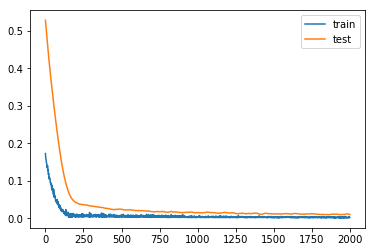

In [14]:
# design network
from keras.layers import LSTM, Dropout
model = Sequential()
#model.add(LSTM(10, batch_input_shape=(1,train_X.shape[1], train_X.shape[2]), stateful=True))
model.add(LSTM(5,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=48, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 41795.234


In [314]:
print(inv_y)

[  888360.       918687.       944400.       916536.       917268.
   919100.9375   919504.       927240.       929353.       937903.
   956250.       970371.0625   972169.9375  1009137.      1030781.
   999029.9375  1001178.       999582.       998032.      1006136.0625]


In [315]:
print(inv_yhat)

[ 889091.625   893201.375   907997.375   916525.5     904385.5     907385.5625
  910564.3125  915239.1875  919602.75    921304.6875  926251.5     935440.875
  943841.9375  945493.375   957582.625   960453.5     945477.5625
  945291.25    944066.75    943671.4375]


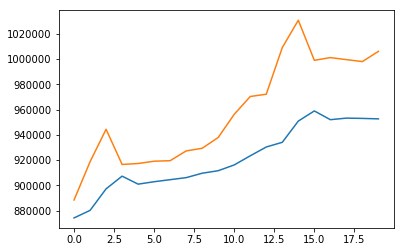

In [16]:
pyplot.plot(inv_yhat)
pyplot.plot(inv_y)
pyplot.show()